In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import glob as glob

from utils.diagnostics import compute_summary_statistics

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [11]:
model_names = ["mvo_lo_sample"]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [12]:
def aggregate_results(path):
    files = glob.glob(os.path.join(path, "*.csv"))

    all_summary = []
    for f in files:
        summary = pd.read_csv(f)

        all_summary.append(summary)
    
    all_summary_df = pd.concat(all_summary)
    all_summary_df.sort_values("date", inplace=True)

    return all_summary_df.reset_index(drop=True)

In [13]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [14]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
mvo_lo_sample,22.119283,50.245655,0.440223,0.646582,-27.080919,-70.677852,0.499334


## 2) Cummulative Returns of the Portfolios

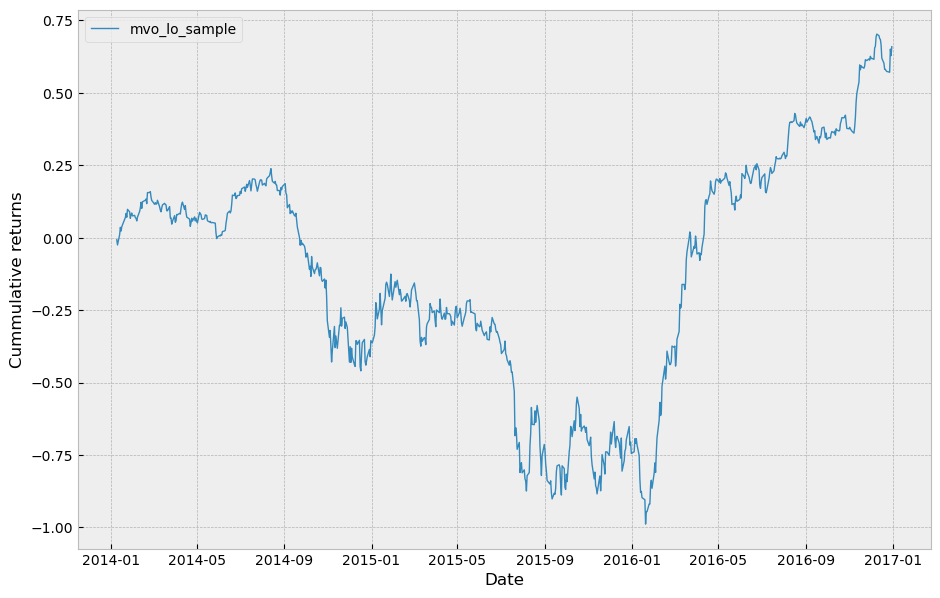

In [15]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2004-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Check weights

In [16]:
check_name = "mvo_lo_sample"

all_summary_df.loc[all_summary_df["model"] == check_name, ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,37550.000000,3.755000e+04,3.755000e+04
mean,0.000221,2.000000e-02,1.755499e-05
std,0.020080,9.788540e-02,3.749793e-03
min,-0.307449,0.000000e+00,-1.144990e-01
25%,-0.008016,0.000000e+00,-4.747897e-20
50%,0.000444,2.420694e-17,0.000000e+00
75%,0.008681,3.400959e-16,9.061132e-20
max,1.117032,1.000000e+00,9.438348e-02


In [17]:
all_summary_df.loc[all_summary_df["returns"] >= 1.11]

,date,ticker,returns,weights,pnl,model
34608,2016-10-07,AA,1.117032,2.934624e-16,3.278067e-16,mvo_lo_sample


<Axes: title={'center': 'AA returns'}, xlabel='date'>

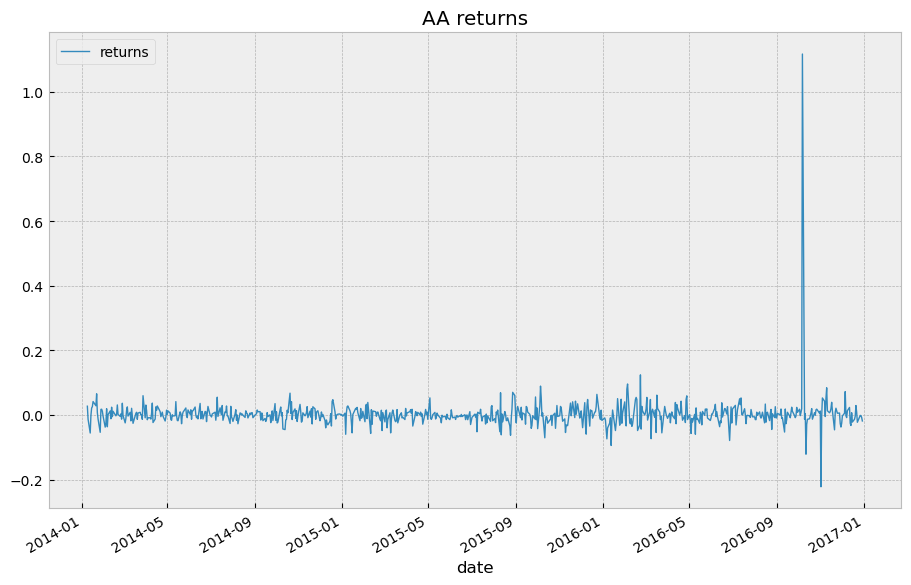

In [18]:
stock_name = "AA"

check_stock_df = all_summary_df.loc[(all_summary_df["model"] == check_name)&(all_summary_df["ticker"] == stock_name)][["date", "returns"]]
check_stock_df["date"] = pd.to_datetime(check_stock_df["date"])
check_stock_df.set_index("date", inplace=True)

check_stock_df.plot(figsize=(11, 7), title="{} returns".format(stock_name))